# Overview

This Jupyter notebook predicts large-area tiles downloaded in `4a-download-large-area` with a trained model from `3-model-master`. The notebook is broken down into the following sections:

   * **Model loading**:
   * **Coordinate identification**
   * **Tiling**
   * **Loading and predicting**
   * **Mosaicing**
   * **Writing TIF**
   * **Writing COG**

In [ ]:
# The old tensorflow is 1.13.1, the new is 1.15.4

# 1.0 Package imports

In [1]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)
from osgeo import ogr, osr
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import rasterio
from rasterio.transform import from_origin
from tqdm import tnrange, tqdm_notebook
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
from scipy.ndimage import median_filter
from skimage.transform import resize
import hickle as hkl
from time import sleep

%run ../src/downloading/utils.py
%run ../src/models/utils.py

Using TensorFlow backend.


# 1.1 Parameter definitions

In [2]:
LANDSCAPE = 'malawi-rumphi'
YEAR = 2019

In [3]:
database = pd.read_csv("../project-monitoring/database.csv")
coords = database[database['landscape'] == LANDSCAPE]
path = coords['path'].tolist()[0]
coords = (float(coords['longitude']), float(coords['latitude']))

IO_PARAMS = {'prefix': '../',
             'bucket': 'restoration-monitoring',
             'coords': coords,
             'bucket-prefix': '',
             'path': path}

OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + '/output/'
TIF_OUTPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + ".tif"
INPUT = IO_PARAMS['prefix'] + IO_PARAMS['path'] + str(YEAR) + '/processed/'

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
print(coords, OUTPUT)

(33.241888, -11.134766) ../project-monitoring/zambia/eastern/chama/2019/output/


# 2.0 Model loading

In [4]:
import urllib.request
import zipfile

if not os.path.exists("../models/master/"):
    os.makedirs("../models/master/")
    
    print("Downloading model file from cloud storage")
    urllib.request.urlretrieve("https://storage.googleapis.com/rm-models/master.zip", "master.zip")
    with zipfile.ZipFile("master.zip", 'r') as zip_ref:
        zip_ref.extractall("../models/")

In [5]:
path = '../models/master-new-data/'
new_saver = tf.train.import_meta_graph(path + 'model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(path))

In [6]:
for i in range(50):
    try:
        logits = tf.get_default_graph().get_tensor_by_name("conv2d_{}/Sigmoid:0".format(i))
    except Exception:
        pass
    
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
length = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")


inp_median = tf.get_default_graph().get_tensor_by_name("Placeholder_4:0")
rmax = tf.get_default_graph().get_tensor_by_name("Placeholder_5:0")
rmin = tf.get_default_graph().get_tensor_by_name("Placeholder_6:0")
dmax = tf.get_default_graph().get_tensor_by_name("Placeholder_7:0")

## 2.2 Tiling functions

In [7]:
def fspecial_gauss(size, sigma):

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """

    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

arr = fspecial_gauss(14, 2)
arr = arr[:7, :7]

SIZE = 10
SIZE_N = SIZE*SIZE
SIZE_UR = (SIZE - 1) * (SIZE - 1)
SIZE_R = (SIZE - 1) * SIZE
SIZE_U = SIZE_R
TOTAL = SIZE_N + SIZE_UR + SIZE_R + SIZE_U
print(SIZE_N, SIZE_UR, SIZE_R, SIZE_U, TOTAL)

arr = np.concatenate([arr, np.flip(arr, 0)], 0)
base_filter = np.concatenate([arr, np.flip(arr, 1)], 1)
normal = np.tile(base_filter, (SIZE, SIZE))
normal[:, 0:7] = 1.
normal[:, -7:] = 1.
normal[0:7, :] = 1.
normal[-7:, :] = 1.
upright = np.tile(base_filter, (SIZE - 1, SIZE - 1))
upright = np.pad(upright, (7, 7), 'constant', constant_values = 0)
right_filter = np.tile(base_filter, (SIZE, SIZE - 1))
right_filter = np.pad(right_filter, ((0, 0), (7, 7)), 'constant', constant_values = 0)
up_filter = np.tile(base_filter, (SIZE - 1, SIZE))
up_filter = np.pad(up_filter, ((7, 7), (0, 0)), 'constant', constant_values = 0)

sums = (up_filter + right_filter + upright + normal)
up_filter /= sums
right_filter /= sums
upright /= sums
normal /= sums

100 81 90 90 361


# 2.3 Prediction functions

In [8]:
min_all = [0.014975665658712386, 0.029106909073889256, 0.017082673106342552, 0.0769551807641983, 
           0.04735258914530277, 0.07149745173752309, 0.0783692590892315, 0.08056833103299141,
           0.05374009419232607, 0.03318566210567951, 0.0, -0.0020877515571191907, -0.03999064572155476,
           -0.0006946590921143062, 0.00635538250207901, 6.103608757257462e-05] 

max_all = [0.19597871720790827, 0.292102221250534, 0.4264908292889595, 0.5075687456130975, 
            0.4700910750031468, 0.4816864275932309, 0.5043602621555328, 0.5157811993360518, 
            0.6546934843063354, 0.5968468230962746, 0.36693188548088074, 0.7097676712274551,
            0.40581784904003115, 0.6523592859506605, 0.7218967080116272, 0.14881360530853271]


def load_and_predict_folder(y_col, folder, overlap_filter = upright,
                            normal_filter = normal, histogram_match = False):
    pred_files = INPUT + str(y_col) + "/" + str(folder) + ".hkl"
    print(pred_files)
    reference_files = f"../tile_data/{LANDSCAPE}/2019/processed/{str(y_col)}/{str(folder)}.hkl"
    
    pred_x = []
    
    clipping_params = {
        'rmax': rmax,
        'rmin': rmin,
        'dmax': dmax
    }

    x = hkl.load(pred_files)
    x = np.float32(x)

    filtered = median_filter(x[0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (71, 2, 71, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (142, 142), 0)
    x[:, :, :, 10] = np.stack([filtered] * x.shape[0])
    
    for band in range(x.shape[-1]):
        if np.max(x[..., band]) > 100:
            x[..., band] /= 65535
    
    x = np.delete(x, 14, -1)
    if x.shape[0] == 24:
        x = np.reshape(x, (12, 2, 142, 142, 16))
        x = np.mean(x, axis = 1)
    to_save = np.copy(x)
    x = tile_images(x)

    pred_x = np.stack(x)   
    for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[..., x] = np.clip(pred_x[..., x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[..., x] - midrange) / (rng / 2)
        pred_x[..., x] = standardized

    preds = []
    batches = [x for x in range(0, 341, 20)] + [361]
    for i in range(len(batches)-1):
        batch_x = pred_x[batches[i]:batches[i+1]]
        median_x = np.median(batch_x, axis = (1))
        lengths = np.full((batch_x.shape[0], 1), 12)
        batch_pred = sess.run(logits, feed_dict={inp:batch_x, 
                                                 inp_median: median_x,
                                                 clipping_params['rmax']: 5,
                                                 clipping_params['rmin']: 0,
                                                 clipping_params['dmax']: 3,
                                                 length:lengths}).reshape(batch_x.shape[0], 14, 14)
        for sample in range(batch_pred.shape[0]):
            preds.append(batch_pred[sample, :, :])
            
    preds_stacked = []
    for i in range(0, SIZE_N, SIZE):
        preds_stacked.append(np.concatenate(preds[i:i + SIZE], axis = 1))
    stacked = np.concatenate(preds_stacked, axis = 0) * normal

    preds_overlap = []
    for scene in range(SIZE_N, SIZE_N+SIZE_UR, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+ (SIZE - 1)], axis = 1)
        preds_overlap.append(to_concat)    
    overlapped = np.concatenate(preds_overlap, axis = 0)
    overlapped = np.pad(overlapped, (7, 7), 'constant', constant_values = 0)
    overlapped = overlapped * upright

    preds_up = []
    for scene in range(SIZE_N+SIZE_UR, SIZE_N+SIZE_UR+SIZE_R, SIZE):
        to_concat = np.concatenate(preds[scene:scene+SIZE], axis = 1)
        preds_up.append(to_concat)   
    up = np.concatenate(preds_up, axis = 0)
    up = np.pad(up, ((7,7), (0,0)), 'constant', constant_values = 0)
    up = up * up_filter
        
    preds_right = []
    for scene in range(SIZE_N+SIZE_UR+SIZE_R, TOTAL, SIZE - 1):
        to_concat = np.concatenate(preds[scene:scene+SIZE-1], axis = 1)
        preds_right.append(to_concat)   
    right = np.concatenate(preds_right, axis = 0)
    right = np.pad(right, ((0, 0), (7, 7)), 'constant', constant_values = 0)
    right = right * right_filter
    
    stacked = stacked + overlapped + right + up
    return stacked, to_save

# Development Code

In [9]:
for row in tnrange(19, 20):
    for column in range(27, 28):
        output_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        input_file = f"{INPUT}{str(row)}/{str(column)}.hkl"
        prediction, _ = load_and_predict_folder(row, column, histogram_match = False)

../project-monitoring/zambia/eastern/chama/2019/processed/19/27.hkl



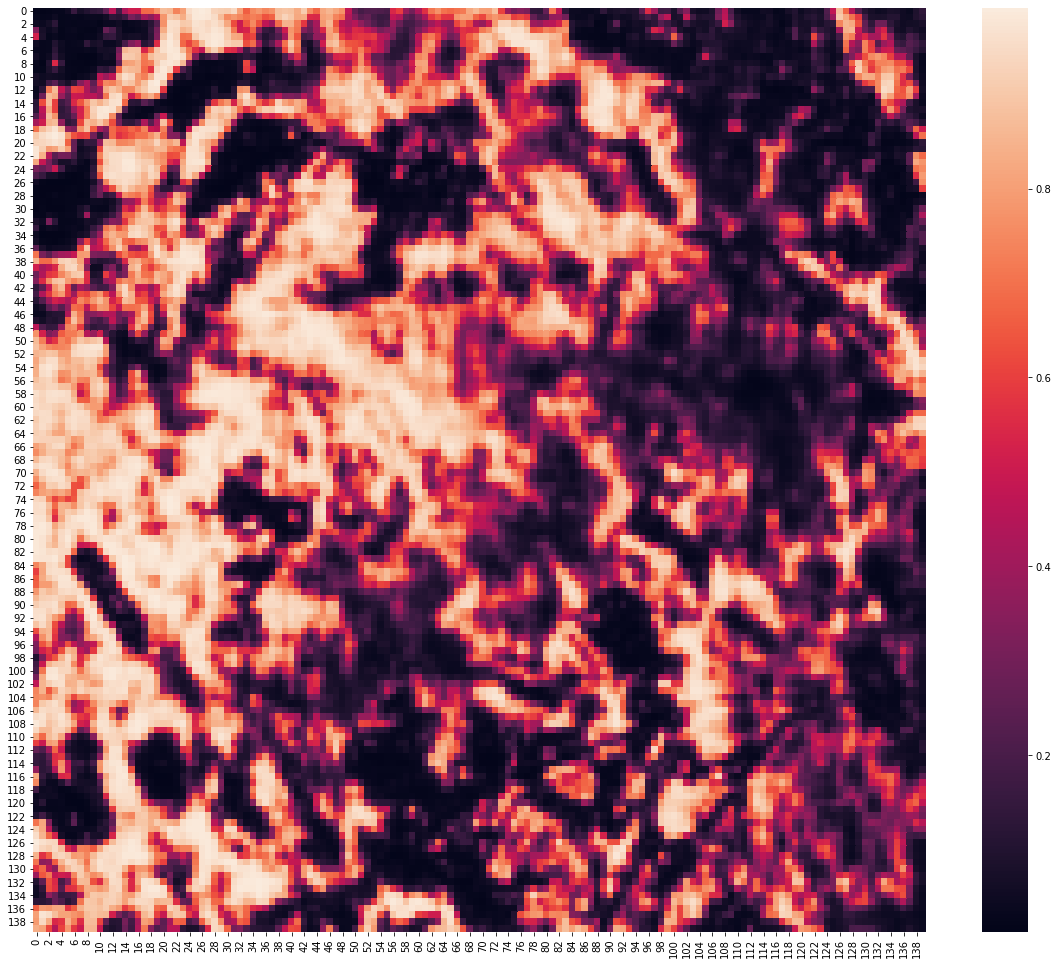

In [12]:
# OLD 190
plt.figure(figsize=(20, 17))
sns.heatmap(prediction)

In [531]:
'''
clipping_params = {
            'rmax': rmax,
            'rmin': rmin,
            'dmax': dmax
        }

for x in range(0, pred_x.shape[-1]):
        mins = min_all[x]
        maxs = max_all[x]
        pred_x[..., x] = np.clip(pred_x[..., x], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (pred_x[..., x] - midrange) / (rng / 2)
        pred_x[..., x] = standardized

def window8(pred_x, offset_x, offset_y):
    preds = np.zeros((140+offset_x, 140+offset_y))
    for p_x in range(0+offset_x, 126, 6):
        for p_y in range(0+offset_y, 126, 6):
            i_x = p_x + 5 # (16 - 10) / 2
            i_y = p_y + 5 # (16 - 10) / 2

            to_do = pred_x[:, i_x - 5 : i_x + 11, i_y - 5: i_y + 11, :]
            median_x = np.median(to_do, axis = (0))
            lengths = np.full((1, 1), 12)
            batch_pred = sess.run(logits, feed_dict={inp:to_do[np.newaxis], 
                                 inp_median: median_x[np.newaxis],
                                 clipping_params['rmax']: 5,
                                 clipping_params['rmin']: 0,
                                 clipping_params['dmax']: 3,
                                 length:lengths})
            pred = batch_pred[0, 4:-4, 4:-4, 0]
            preds[p_x: p_x + 6, p_y:p_y + 6] = pred
    return preds


%time p0 = window8(pred_x, 0, 0)
p1 = window8(pred_x, 1, 1)
p2 = window8(pred_x, 2, 2)
p3 = window8(pred_x, 3, 3)
'''

CPU times: user 18.6 s, sys: 1.95 s, total: 20.5 s
Wall time: 6.25 s


# 2.4 Run predictions

In [100]:
all_preds = []
for row in tnrange((0*5), (5*5)): 
    for column in range(0*5, (6*5)):
        output_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        input_file = f"{INPUT}{str(row)}/{str(column)}.hkl"

        if os.path.exists(input_file) and not os.path.exists(output_file):
            prediction = load_and_predict_folder(row, column, histogram_match = False)
            if not os.path.exists(OUTPUT + str(row) + "/"):
                os.makedirs(OUTPUT + str(row) + "/")
            prediction = prediction[7:-7, 7:-7]
            np.save(output_file, prediction)

../project-monitoring/zambia/eastern/chama/2019/processed/20/25.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/20/26.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/20/27.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/20/28.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/20/29.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/21/25.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/21/26.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/21/27.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/21/28.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/21/29.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/22/25.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/22/26.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/22/27.hkl
../project-monitoring/zambia/eastern/chama/2019/processed/22/28.hkl
../project-monitoring/zambia/eastern/chama/2019/


# 2.5 Mosaic predictions

In [101]:
max_x = 6*5
max_y = 6*5

start_x = 0*5
start_y = 0*5

predictions = np.full(
    ((max_y-start_y)*126,
     (max_x-start_x)*126), 0, dtype = np.uint8 )

max_y_out = predictions.shape[0]
max_x_out = predictions.shape[1]

numb = 0
for row in tnrange(start_y, max_y):
    for column in range(start_x, max_x):
        input_file = f"{OUTPUT}{str(row)}/{str(column)}.npy"
        if os.path.exists(input_file):
            prediction = np.load(input_file)
            x_value = (column-start_x) *126
            y_value = (max_y_out - ((row - start_y + 1) *126))
            if (row % 5 == 0) and (column % 5 == 0):
                numb += 1
            predictions[y_value:y_value+126, 
                        x_value:x_value+126,
                        ] = (prediction * 255).astype(np.uint8)
            
predictions[predictions < 30] = 0.
print(f"There are {numb*4000} hectares processed")



There are 88000 hectares processed


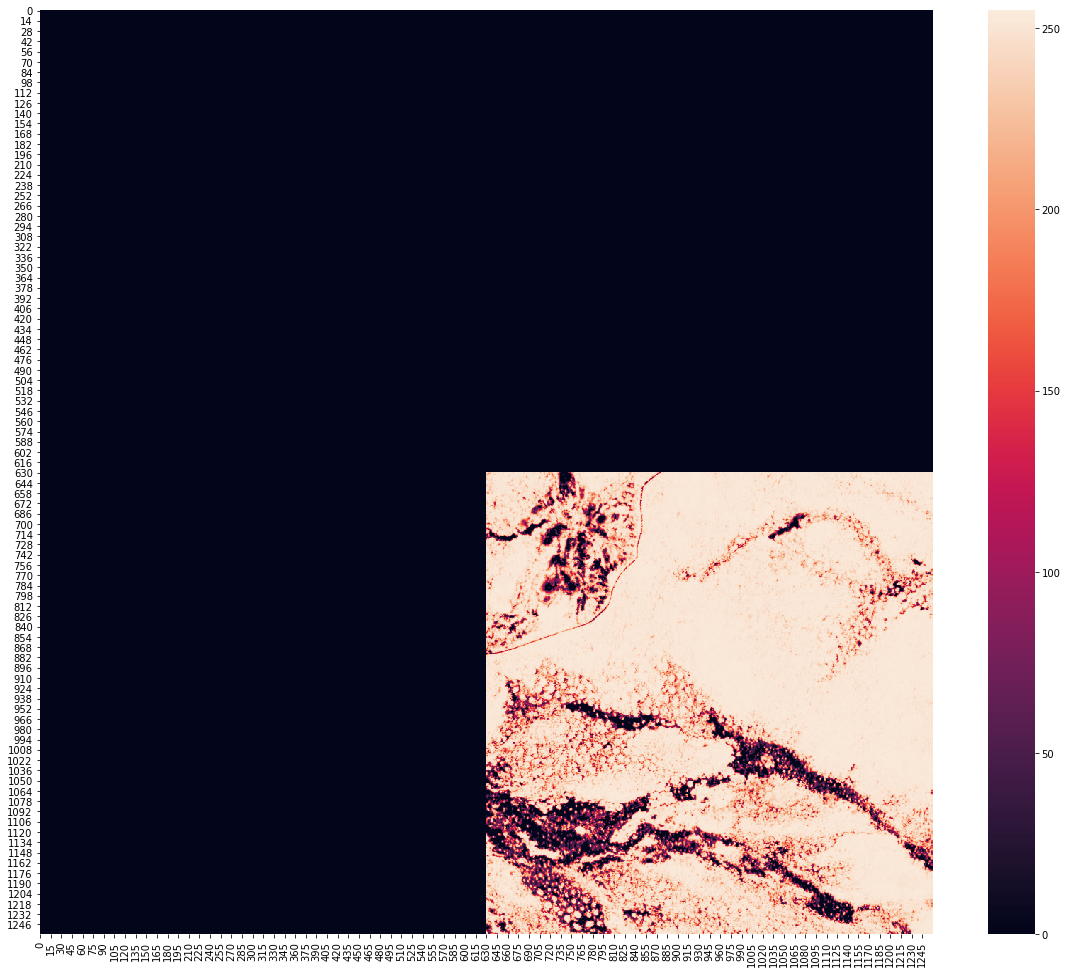

In [102]:
plt.figure(figsize=(20, 17))
sns.heatmap(predictions[:1260, :1260], vmin = 0, vmax = 255.)

#### 2.6 Sharpen predictions

In [103]:
def recover_new(arr, thresh):
    adding = 0
    stacked = np.copy(arr)
    for window_x in tnrange(2, stacked.shape[0]-2, 1):
        for window_y in range(2, stacked.shape[1]-2, 1):
            #
            five_w = stacked[window_x-2:window_x+3, window_y-2:window_y+3]
            three_w = stacked[window_x-1:window_x+2, window_y-1:window_y+2]
            
            n_five_above = len(five_w[np.argwhere(five_w > 0.15)])
            n_three_above = len(three_w[np.argwhere(three_w > 0.15)])
            
            n_five_below = len(five_w[np.argwhere(five_w < thresh)])
            
            
            if n_five_below >= 24:                 # if less than 2 of the 5x5 are positive
                if n_three_above >= 2 and n_three_above < 6:             # and at least 2 of the 3x3 are above 0.1
                    if n_three_above <= (n_five_above + 4):  # and less than 1/4 of the outer border is above 0.1
                        if np.argmax(three_w) == 4:          # and the center of the 3 x 3 is the largest
                            stacked[window_x, window_y] = -1.
                            #print("adding")
                            adding += 1
    stacked[np.where(stacked == -1)] = 1.
    return stacked

In [104]:
stacked = predictions
#stacked = recover_new(predictions, 0.3)
#stacked[np.where(stacked < 0.3)] = 0.

In [105]:
#plt.figure(figsize=(20, 17))
#thresh_p = 0.55
#stacked = predictions
#stacked[np.where(stacked > thresh_p)] = 0.71
#stacked[np.where(stacked < thresh_p)] = -1
#stacked[np.where(stacked == 1.0)] = 1.
#sns.heatmap(stacked)

# 3.0 Write GeoTiff

In [106]:
point = bounding_box(coords, (max_x*1260)-0, ((max_y)*1260)-0, expansion = 0)
west = point[1][0]
east = point[0][0]
north = point[0][1]
south = point[1][1]
print(max_y)

30


In [107]:
stacked[np.where(stacked < 0)] = 0.
stacked = stacked.astype(np.uint8)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = stacked.shape[1], height = stacked.shape[0])

print("Writing", TIF_OUTPUT)
new_dataset = rasterio.open(TIF_OUTPUT, 'w', driver = 'GTiff',
                           height = stacked.shape[0], width = stacked.shape[1], count = 1,
                           dtype = 'uint8',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(stacked, 1)
new_dataset.close()

Writing ../project-monitoring/zambia/eastern/chama/2019.tif


# 3.1 Cloud optimized Geotiff

In [ ]:
!gdal_translate ../../ce-hosting/includes/drc-kafubu.tif ../tile_data/cog/drc-kafubu.tif \
               -co TILED=YES -co COMPRESS=LZW
!gdaladdo -r average -ro ../tile_data/cog/drc-kafubu.tif 2 4 8 16
#!gsutil cp niger.tif gs://restoration-hosting/niger.tif

# 3.2 Half-hectare tree density Geotiff

In [ ]:
summed = np.reshape(stacked, (stacked.shape[0] // 6, 6, stacked.shape[1] // 6, 6))
summed = np.sum(summed, (1, 3))
summed /= np.max(summed)
summed = np.clip(summed, 0, 0.8)
summed += 0.1

In [ ]:

summed = summed.astype(np.float32)
transform = rasterio.transform.from_bounds(west = west, south = south,
                                           east = east, north = north,
                                           width = summed.shape[1], height = summed.shape[1])

new_dataset = rasterio.open('../../ce-hosting/includes/bonanza1.tif', 'w', driver = 'GTiff',
                           height = summed.shape[1], width = summed.shape[1], count = 1,
                           dtype = 'float32',#str(stacked.dtype),
                           crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs',
                           transform=transform)
new_dataset.write(summed, 1)
new_dataset.close()